In [2]:
import matplotlib
import matplotlib.pyplot as plt

from astropy.modeling.functional_models import Gaussian2D
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve_fft as convolve

from astropy import constants as const
from astropy import units as u

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70.00,Om0=0.30)

import numpy as np
import scipy.integrate

try: 
    import numba
    nonumba = False
except:
    nonumba = True
    
rng = np.random.default_rng(5786)


Below are some functions for taking care of different spectral scaling (tSZ, dust, ...)

In [3]:
# Dust-like (greybody) spectrum
# ----------------------------------------------------------------------
def sdust(nu,nu0=100*u.GHz,A0=1.00,bdust=1.50,Tdust=10*u.Kelvin):
    factor = (nu/nu0)**(bdust+3)
    factor = factor*np.expm1((const.h*nu0/const.k_B/Tdust).to(u.dimensionless_unscaled))
    factor = factor/np.expm1((const.h*nu/const.k_B/Tdust).to(u.dimensionless_unscaled))
    return A0*factor

# Power law spectrum
# ----------------------------------------------------------------------
def spowr(nu,nu0=100*u.GHz,alpha=-0.70):
    return (nu/nu0)**alpha


Tcmb = 2.7255*u.Kelvin

# Adimensional frequency
# ----------------------------------------------------------------------
def getx(freq):
    factor = const.h*freq.to(u.Hz)/const.k_B/Tcmb
    return factor.to(u.dimensionless_unscaled).value

# CMB surface brightness
# ----------------------------------------------------------------------
def getJynorm():
    factor  = 2e26
    factor *= (const.k_B*Tcmb)**3
    factor /= (const.h*const.c)**2
    return factor.value

# Jy/beam to Jy/pix
# ----------------------------------------------------------------------
def JyBeamToJyPix(ipix,jpix,bmaj,bmin):
    return np.abs(ipix*jpix)*(4*np.log(2))/(np.pi*bmaj*bmin)

# Jy/deg2 to Jy/pix
# ----------------------------------------------------------------------
def JyDegsToJyPix(ipix,jpix,bmaj,bmin):
    return np.abs(ipix*jpix)

# Kelvin CMB to Kelvin brightness
# ----------------------------------------------------------------------
def KcmbToKbright(freq): 
    x = getx(freq)
    return np.exp(x)*((x/np.expm1(x))**2)

# Kelvin brightness to Jy/pixel
# ----------------------------------------------------------------------
def KbrightToJyPix(freq,ipix,jpix):
    return KcmbToJyPix(freq,ipix,jpix)/KcmbToKbright(freq)

# Kelvin CMB to Jy/pixel
# ----------------------------------------------------------------------
def KcmbToJyPix(freq,ipix,jpix):
    x = getx(freq)
    factor  = getJynorm()/Tcmb.value
    factor *= (x**4)*np.exp(x)/(np.expm1(x)**2)
    factor *= np.abs(ipix*jpix)*(np.pi/1.8e2)*(np.pi/1.8e2)
    return factor

# Compton y to Jy/pixel
# ----------------------------------------------------------------------
def comptonToJyPix(freq,ipix,jpix):
    x = getx(freq)
    factor  = getJynorm()
    factor *= -4.0+x/np.tanh(0.5*x)
    factor *= (x**4)*np.exp(x)/(np.expm1(x)**2)
    factor *= np.abs(ipix*jpix)*(np.pi/1.8e2)*(np.pi/1.8e2)
    return factor

The bit below generates a Compton y map assuming a basic A10 model for given m500 and redshift. It requires an input grid of x/y distances from the cluster center.

In [4]:
# Get gNFW model grid
# ----------------------------------------------------------------------
def getgnfw(pgrid,m500,z,profile='a10_up',fb=0.175,mu=0.590,mue=1.140):
    if profile[:-3]=='a10':
        if   profile[-2:]=='cc': # cool core
            alpha = 1.2223E+00; beta = 5.4905E+00; gamma =  7.7360E-01
            pnorm = 3.2490E+00; c500 = 1.1280E+00; ap    =  1.2000E-01
        elif profile[-2:]=='md': # morphologically disturbed
            alpha = 1.4063E+00; beta = 5.4905E+00; gamma =  3.7980E-01
            pnorm = 3.2020E+00; c500 = 1.0830E+00; ap    =  1.2000E-01
        elif profile[-2:]=='up': # universal profile
            alpha = 1.0510E+00; beta = 5.4905E+00; gamma =  3.0810E-01
            pnorm = 8.4030E+00; c500 = 1.1770E+00; ap    =  1.2000E-01
    
    def p(x,xi):
        factor = 1.00/(c500*x)**gamma
        factor = factor*(1.00+(c500*x)**alpha)**((gamma-beta)/alpha)
        factor = factor*(((m500/(3.00E+14*u.M_sun)).to(u.dimensionless_unscaled).value)**((ap+0.10)/(1.00+(2.00*x)**3.00)))
        factor = factor*(x/((x*x-xi*xi)**0.50))
        return pnorm*factor
    
    r500 = ((3.00/4.00/np.pi/500.00/cosmo.critical_density(z))*m500)**(1.00/3.00)
    r500 = r500.to(u.Mpc)
    
    s500 = (r500/cosmo.angular_diameter_distance(z)).to(u.dimensionless_unscaled)
    s500 = np.rad2deg(s500.value)*u.deg
    
    p500 = (3.00/8.00/np.pi)*(fb*mu/mue)
    p500 *= (((((2.5e2*cosmo.H(z)*cosmo.H(z))**2.00)*m500/(const.G**(0.50)))**(2.00/3.00)).to(u.keV/u.cm**3))

    
    ynorm = const.sigma_T/const.m_e/const.c**2
    ynorm = ynorm.to(u.cm**2/u.keV)
    
    xline = np.append(0.00,np.logspace(-7,2,100))
    mline = np.array([scipy.integrate.quad(p,x,np.inf,args=(x))[0] for x in xline])
    mline = (2.00*r500*ynorm*p500*mline).to(u.dimensionless_unscaled)
    
    mgrid = np.hypot(pgrid[0],pgrid[1])
    mgrid = np.interp(mgrid.to(u.deg),xline*s500,mline)
    
    return mgrid

Let's generate things

In [15]:
from atlast_sc.calculator import Calculator

# Setting up coordinate grid
# ------------------------------------------------
naxis, cdelt = 1024, 1.00*u.arcsec

pline = np.linspace(0,1,naxis)-0.50
pline = pline*naxis*cdelt

pgrid = np.meshgrid(pline,pline)

# Adding a spherical SZ component
# ------------------------------------------------
ygrid = getgnfw(pgrid,1.00E+14*u.M_sun,1.00)

# Generating point source distribution
# ------------------------------------------------
ncomp = 5
xcomp = rng.normal(size=ncomp,loc=0.00,scale=20.00)*u.arcsec
ycomp = rng.normal(size=ncomp,loc=0.00,scale=20.00)*u.arcsec

ipowr = 10**rng.uniform(size=ncomp,low=-6,high=-3)
idust = 10**rng.uniform(size=ncomp,low=-6,high=-3)
tdust = rng.uniform(size=ncomp,low=1.00,high=30.00)*u.Kelvin

# Generating band realizations
# ------------------------------------------------
iband = [{'freq':  90.00*u.GHz, 'width': 2.00*u.GHz, 'time': 1.00*u.hour},
         {'freq': 110.00*u.GHz, 'width': 2.00*u.GHz, 'time': 1.00*u.hour},
         {'freq': 300.00*u.GHz, 'width': 2.00*u.GHz, 'time': 1.00*u.hour}]

mcube = np.zeros((len(iband),*ygrid.shape))
for bi, band in enumerate(iband):
    print(band)

    flow = (band['freq']-0.50*band['width']).to(u.GHz).value
    fupp = (band['freq']+0.50*band['width']).to(u.GHz).value

    calc = Calculator()
    calc.obs_freq  = band['freq']
    calc.bandwidth = band['width']

    freq = calc.user_input.obs_freq.value
    dish = calc.instrument_setup.dish_radius.value

    fwhm = ((1.20*const.c/(freq*(2.00*dish))).to(u.dimensionless_unscaled)*u.radian).to(u.arcsec)
  
    beam = fwhm/np.sqrt(8.00*np.log(2.00))/cdelt
    beam = beam.to(u.dimensionless_unscaled).value

    area = np.pi*(fwhm**2)/4.00/np.log(2.00)

    yconv = lambda x: comptonToJyPix(x*u.GHz,1.00,1.00)/ \
                       JyBeamToJyPix(1.00,1.00,fwhm.to(u.deg).value,fwhm.to(u.deg).value)

    mconv = scipy.integrate.quad(yconv,flow,fupp)[0]/band['width'].to(u.GHz).value

    mgrid = convolve(ygrid*mconv,Gaussian2DKernel(beam))

    for nc in range(ncomp):
        model = Gaussian2D(amplitude = 1.00,
                              x_mean = xcomp[nc],
                              y_mean = ycomp[nc], 
                            x_stddev = fwhm/np.sqrt(8.00/np.log(2.00)),
                            y_stddev = fwhm/np.sqrt(8.00/np.log(2.00)))
        mspec  = ipowr[nc]*scipy.integrate.quad(lambda x: spowr(x*u.GHz,nu0=100*u.GHz),flow,fupp)[0]/band['width'].to(u.GHz).value
        mspec += idust[nc]*scipy.integrate.quad(lambda x: sdust(x*u.GHz,nu0=100*u.GHz,Tdust=tdust[nc]),flow,fupp)[0]/band['width'].to(u.GHz).value
        mgrid += model(pgrid[0],pgrid[1])*mspec

    scale = calc.calculate_sensitivity(band['time']).to(u.Jy)/area.to(u.deg**2)
    scale = scale.value*(cdelt.to(u.deg)**2).value

    ngrid = rng.normal(size=mgrid.shape,loc=0.00,scale=scale)*(area.to(u.deg**2)/cdelt.to(u.deg)**2).value

    mcube[bi] = mgrid+ngrid

{'freq': <Quantity 90. GHz>, 'width': <Quantity 2. GHz>, 'time': <Quantity 1. h>}
{'freq': <Quantity 110. GHz>, 'width': <Quantity 2. GHz>, 'time': <Quantity 1. h>}
{'freq': <Quantity 300. GHz>, 'width': <Quantity 2. GHz>, 'time': <Quantity 1. h>}


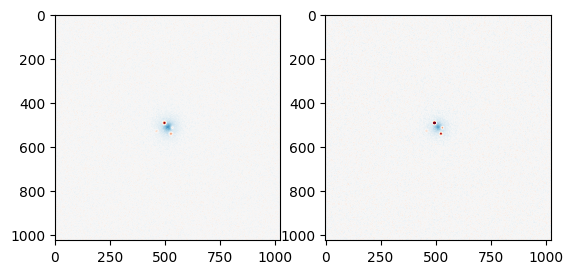

In [16]:
plt.subplot(121); plt.imshow(mcube[0],cmap='RdBu_r',vmin=-0.80*np.nanmax(mcube[0]),vmax=0.80*np.nanmax(mcube[0]))
plt.subplot(122); plt.imshow(mcube[1],cmap='RdBu_r',vmin=-0.80*np.nanmax(mcube[0]),vmax=0.80*np.nanmax(mcube[0]))
plt.show(); plt.close()